There is more documentation in here: http://smtn-002.lsst.io/en/latest/ and here: https://docushare.lsstcorp.org/docushare/dsweb/Get/LSE-40

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.table

In [215]:
from scipy.stats import binned_statistic

The 5-$\sigma$ median depth for point sources is computed as the magnitude from a flat SED in a Gaussian aperture that yields an $SNR=5$. We tried two different approaches: One is to analyze the median magnitude of the galaxies where $\sigma_{iso} \geq 5$. The other approach is to simulate stars and check which magnitude corresponds to a median $SNR=5$. We proceed using `scipy.stats.binned_statistic` and choosing the bin where the median $SNR$ is closest to 5. 

In [284]:
def calculate_depth(band,make_plot=False, exptime=6900., X=1.2, mode='Ivezic', snr_name='snr_iso', make_plot2=False):
    #Values from Ivezic 2014
    if mode=='Ivezic':
        msky = {'u':22.9, 'g':22.3, 'r':21.2, 'i':20.5, 'z':19.6, 'y':18.6}
        cm = {'u':22.92 , 'g':24.29, 'r':24.33, 'i':24.20, 'z':24.07, 'y':23.69} 
        psf = {'u':0.77 , 'g':0.73, 'r':0.70, 'i':0.67, 'z':0.65, 'y':0.63} 
        inst_noise_corr = {'u':0.67 , 'g':0.21, 'r':0.11, 'i':0.08, 'z':0.05, 'y':0.04}
        km = {'u':0.451,'g':0.163,'r':0.087,'i':0.065,'z':0.043,'y':0.138}
    ####################
    #Values from https://github.com/lsst-pst/syseng_throughputs/blob/master/plots/table2
    if mode=='Sys_eng':
        psf = {'u':0.92 , 'g':0.87, 'r':0.83, 'i':0.80, 'z':0.78, 'y':0.76} 
        cm = {'u':22.74, 'g':24.38, 'r':24.43, 'i':24.30 , 'z':24.15, 'y':23.70}
        msky = {'u':22.95, 'g':22.24, 'r':21.20, 'i':20.47, 'z':19.60, 'y':18.63}
        inst_noise_corr = {'u':0.75 , 'g':0.19, 'r':0.10, 'i':0.07, 'z':0.05, 'y':0.04}
        km = {'u':0.5041,'g':0.2097,'r':0.1263,'i':0.0962,'z':0.0685,'y':0.1760}
    
    exptime_corr = {'u':0.,'g':0.,'r':0,'i':0,'z':0,'y':0} #This is going to be the electronic noise correction placeholder
    exptime_corr[band] = inst_noise_corr[band]-1.25*np.log10(1+(10**(0.8*inst_noise_corr[band])-1)/(exptime/30.))
    fid_depth = cm[band]+0.5*(msky[band]-21.)+2.5*np.log10(0.7/psf[band]*X**0.6)-km[band]*(X-1)+1.25*np.log10(exptime/30.)+exptime_corr[band]
    colors = {'u':'violet','g':'blue','r':'green','i':'yellow','z':'orange','y':'red'}
    source_table = astropy.table.Table.read('./WeakLensingDeblending/LSST_%s_stars_4096_4096.fits' %(band))
    if make_plot:
        plt.hist(source_table['ab_mag'][source_table[snr_name]>5.],alpha=0.5,label='%s-band' %band, color=colors[band])
        plt.plot(fid_depth*np.ones_like(np.arange(0,250,50)),np.arange(0,250,50),color=colors[band])
        plt.xlabel('mag$_{AB}$')
        plt.ylabel('Counts')
        plt.legend(loc='best')
        #plt.xlim(17,28.5)
    maxdepth = np.nanmax(source_table['ab_mag'][source_table[snr_name]>5.])
    mediandepth = np.nanmedian(source_table['ab_mag'][source_table[snr_name]>5.])
    meandepth = np.nanmean(source_table['ab_mag'][source_table[snr_name]>5.])
    mad = np.nanmedian(np.fabs(source_table['ab_mag'][source_table[snr_name]>5.]-mediandepth))
    median_snr, bin_edges, binnumber = binned_statistic(source_table['ab_mag'],source_table['snr_iso'],statistic='median',bins=50,range=[(22,30)])
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    mask = np.isnan(median_snr)==False
    median_snr = median_snr[mask]
    bin_centers = bin_centers[mask]
    depth = bin_centers[np.argmin(np.fabs(median_snr-5))]
    delta_depth = bin_centers[1]-bin_centers[0]
    print 'Band: ',band, 'median 5-sigma depth = ', depth, '+-', delta_depth, ' Fiducial value = ', fid_depth
    if make_plot2:
        plt.figure()
        mask2 = np.logical_and(source_table['ab_mag']>=depth-delta_depth,source_table['ab_mag']<=depth+delta_depth)
        plt.hist(source_table['snr_iso'][mask2],range=(0,10),color=colors[band],label='%s-band' %band, alpha=0.5)
        plt.legend(loc='best')
    return maxdepth, mediandepth

In [285]:
for band in ['u','g','r','i','z','y']:
    calculate_depth(band, mode='Ivezic', exptime=30, X=1.0)

Band:  u median 5-sigma depth =  27.04 +- 0.32  Fiducial value =  23.7665182871
Band:  g median 5-sigma depth =  27.84 +- 0.16  Fiducial value =  24.8944379497
Band:  r median 5-sigma depth =  27.2 +- 0.16  Fiducial value =  24.43
Band:  i median 5-sigma depth =  26.72 +- 0.16  Fiducial value =  23.9975580933
Band:  z median 5-sigma depth =  26.08 +- 0.16  Fiducial value =  23.4504617084
Band:  y median 5-sigma depth =  25.28 +- 0.16  Fiducial value =  22.6043937264


In [286]:
for band in ['u','g','r','i','z','y']:
    calculate_depth(band, mode='Sys_eng', exptime=30, X=1.0)

Band:  u median 5-sigma depth =  27.04 +- 0.32  Fiducial value =  23.4182755317
Band:  g median 5-sigma depth =  27.84 +- 0.16  Fiducial value =  24.7639469685
Band:  r median 5-sigma depth =  27.2 +- 0.16  Fiducial value =  24.3450498691
Band:  i median 5-sigma depth =  26.72 +- 0.16  Fiducial value =  23.8900201326
Band:  z median 5-sigma depth =  26.08 +- 0.16  Fiducial value =  23.3325085933
Band:  y median 5-sigma depth =  25.28 +- 0.16  Fiducial value =  22.4257111193


Band:  u median 5-sigma depth =  27.04 +- 0.32  Fiducial value =  27.4115314871
Band:  g median 5-sigma depth =  27.84 +- 0.16  Fiducial value =  28.1416559595
Band:  r median 5-sigma depth =  27.2 +- 0.16  Fiducial value =  27.5930017621
Band:  i median 5-sigma depth =  26.72 +- 0.16  Fiducial value =  27.1351151251
Band:  z median 5-sigma depth =  26.08 +- 0.16  Fiducial value =  26.5625657032
Band:  y median 5-sigma depth =  25.28 +- 0.16  Fiducial value =  25.6875449399


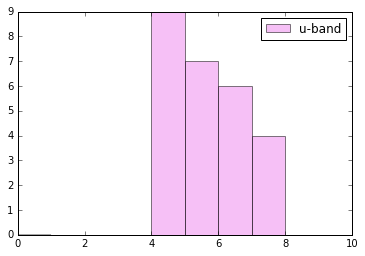

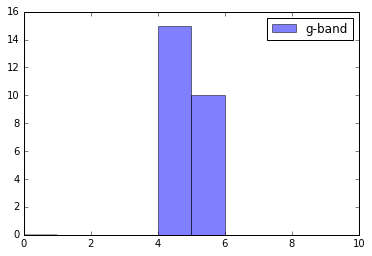

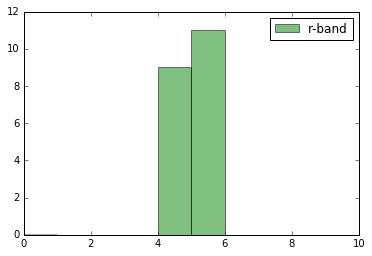

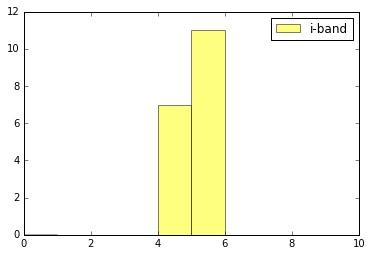

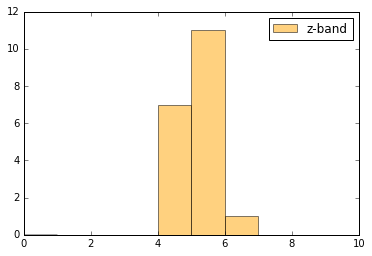

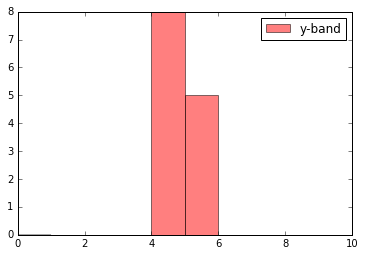

In [287]:
for band in ['u','g','r','i','z','y']:
    calculate_depth(band, make_plot=False, make_plot2=True, mode='Ivezic', exptime=6900, X=1.2)

Band:  u median 5-sigma depth =  27.04 +- 0.32  Fiducial value =  27.1313961924
Band:  g median 5-sigma depth =  27.84 +- 0.16  Fiducial value =  27.9819504327
Band:  r median 5-sigma depth =  27.2 +- 0.16  Fiducial value =  27.490244339
Band:  i median 5-sigma depth =  26.72 +- 0.16  Fiducial value =  27.0113870527
Band:  z median 5-sigma depth =  26.08 +- 0.16  Fiducial value =  26.439512588
Band:  y median 5-sigma depth =  25.28 +- 0.16  Fiducial value =  25.5012623329


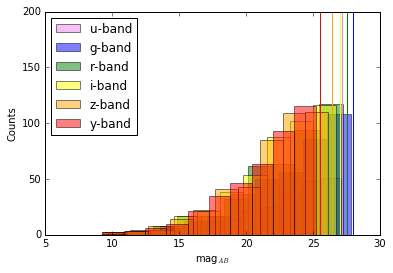

In [288]:
for band in ['u','g','r','i','z','y']:
    calculate_depth(band, make_plot=True,mode='Sys_eng', exptime=6900, X=1.2)